## Load data

In [1]:
# First upload peptide txt files from the github repo.
from google.colab import files
uploaded = files.upload()

Saving ebola-6mers.txt to ebola-6mers.txt
Saving hcmv-6mers.txt to hcmv-6mers.txt
Saving hepb-6mers.txt to hepb-6mers.txt
Saving hepc-6mers.txt to hepc-6mers.txt
Saving hiv-6mers.txt to hiv-6mers.txt
Saving lis-6mers.txt to lis-6mers.txt
Saving mal-6mers.txt to mal-6mers.txt
Saving self-6mers.txt to self-6mers.txt
Saving self1-6mers.txt to self1-6mers.txt
Saving self2-6mers.txt to self2-6mers.txt
Saving vac-6mers.txt to vac-6mers.txt
Saving zika-6mers.txt to zika-6mers.txt


In [35]:
from collections import defaultdict

SELF_6MERS = ['self1-6mers.txt', 'self2-6mers.txt']
VIRUS_6MERS = [
  'ebola-6mers.txt', 'hcmv-6mers.txt', 'hepb-6mers.txt', 'hepc-6mers.txt',
  'hiv-6mers.txt', 'lis-6mers.txt', 'mal-6mers.txt', 'vac-6mers.txt', 
  'zika-6mers.txt']

file_to_peptides = defaultdict(list)
unique_aminos = set()
for file in SELF_6MERS + VIRUS_6MERS:
  with open(file, 'rb') as f:
    count = 0
    for line in f.readlines():
      peptide = line.decode('utf-8').strip()
      count += 1
      file_to_peptides[file].append(peptide)
      for amino in peptide:
        unique_aminos.add(amino)

    print('{} peptides in file {}'.format(count, file))

262000 peptides in file self1-6mers.txt
1216 peptides in file self2-6mers.txt
140 peptides in file ebola-6mers.txt
2090 peptides in file hcmv-6mers.txt
65 peptides in file hepb-6mers.txt
112 peptides in file hepc-6mers.txt
69 peptides in file hiv-6mers.txt
31476 peptides in file lis-6mers.txt
89408 peptides in file mal-6mers.txt
1955 peptides in file vac-6mers.txt
118 peptides in file zika-6mers.txt


## Basic stats/univariate distributions

### Overlap between Self/Virus and Virus/Virus peptides

num unique self peptides = 263216
num self dupes = 0
num unique virus peptides = 123180
num virus dupes = 2253


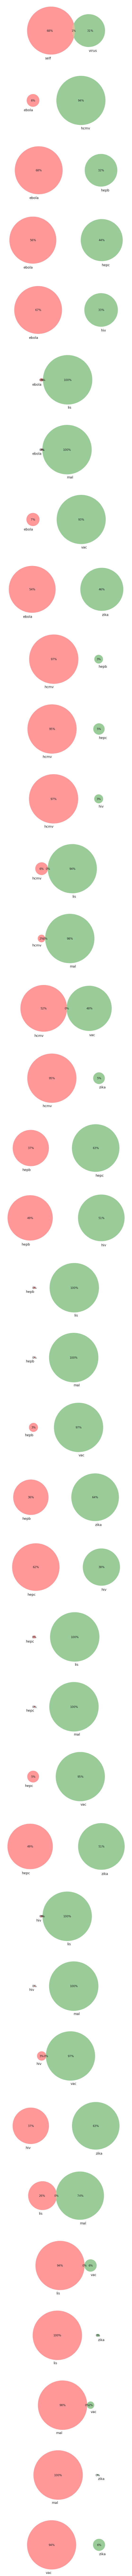

In [88]:
self_peptides, unique_self_peptides = [], set()
num_self_dupes = 0
for file in SELF_6MERS:
  for peptide in file_to_peptides[file]:
    self_peptides.append(peptide)
    if peptide in unique_self_peptides:
      num_self_dupes += 1
    unique_self_peptides.add(peptide)

print('num unique self peptides = {}'.format(len(unique_self_peptides)))
print('num self dupes = {}'.format(num_self_dupes))

file_to_virus_peptides = defaultdict(list)
virus_peptides, unique_virus_peptides = [], set()
num_virus_dupes = 0
for file in VIRUS_6MERS:
  for peptide in file_to_peptides[file]:
    file_to_virus_peptides[file].append(peptide)
    virus_peptides.append(peptide)
    if peptide in unique_virus_peptides:
      num_virus_dupes += 1
    unique_virus_peptides.add(peptide)

print('num unique virus peptides = {}'.format(len(unique_virus_peptides)))
print('num virus dupes = {}'.format(num_virus_dupes))

from matplotlib_venn import venn2
def venn(set_a, set_b, set_labels, ax):
  total = len(set_a.union(set_b))
  v1 = venn2(
      [set_a, set_b],
      set_labels=set_labels,
      set_colors=['red', 'green'],
      subset_label_formatter=lambda x: f"{(x/total):1.0%}",
      ax=ax
  )

fig, axs = plt.subplots(37, figsize=(14, 200))

venn(unique_self_peptides, 
     unique_virus_peptides, 
     ['self', 'virus'],
     axs[0])

index = 0
for i in range(len(VIRUS_6MERS)):
  file_i = VIRUS_6MERS[i]
  unique_peptides_i = set(file_to_virus_peptides[file_i])
  for j in range(i + 1, len(VIRUS_6MERS)):
    file_j = VIRUS_6MERS[j]
    unique_peptides_j = set(file_to_virus_peptides[file_j])
    venn(unique_peptides_i, 
         unique_peptides_j, 
         [file_i[:file_i.index('-')], 
          file_j[:file_j.find('-')]],
         ax=axs[index + 1])
    index += 1

### Amino Acid Distributions

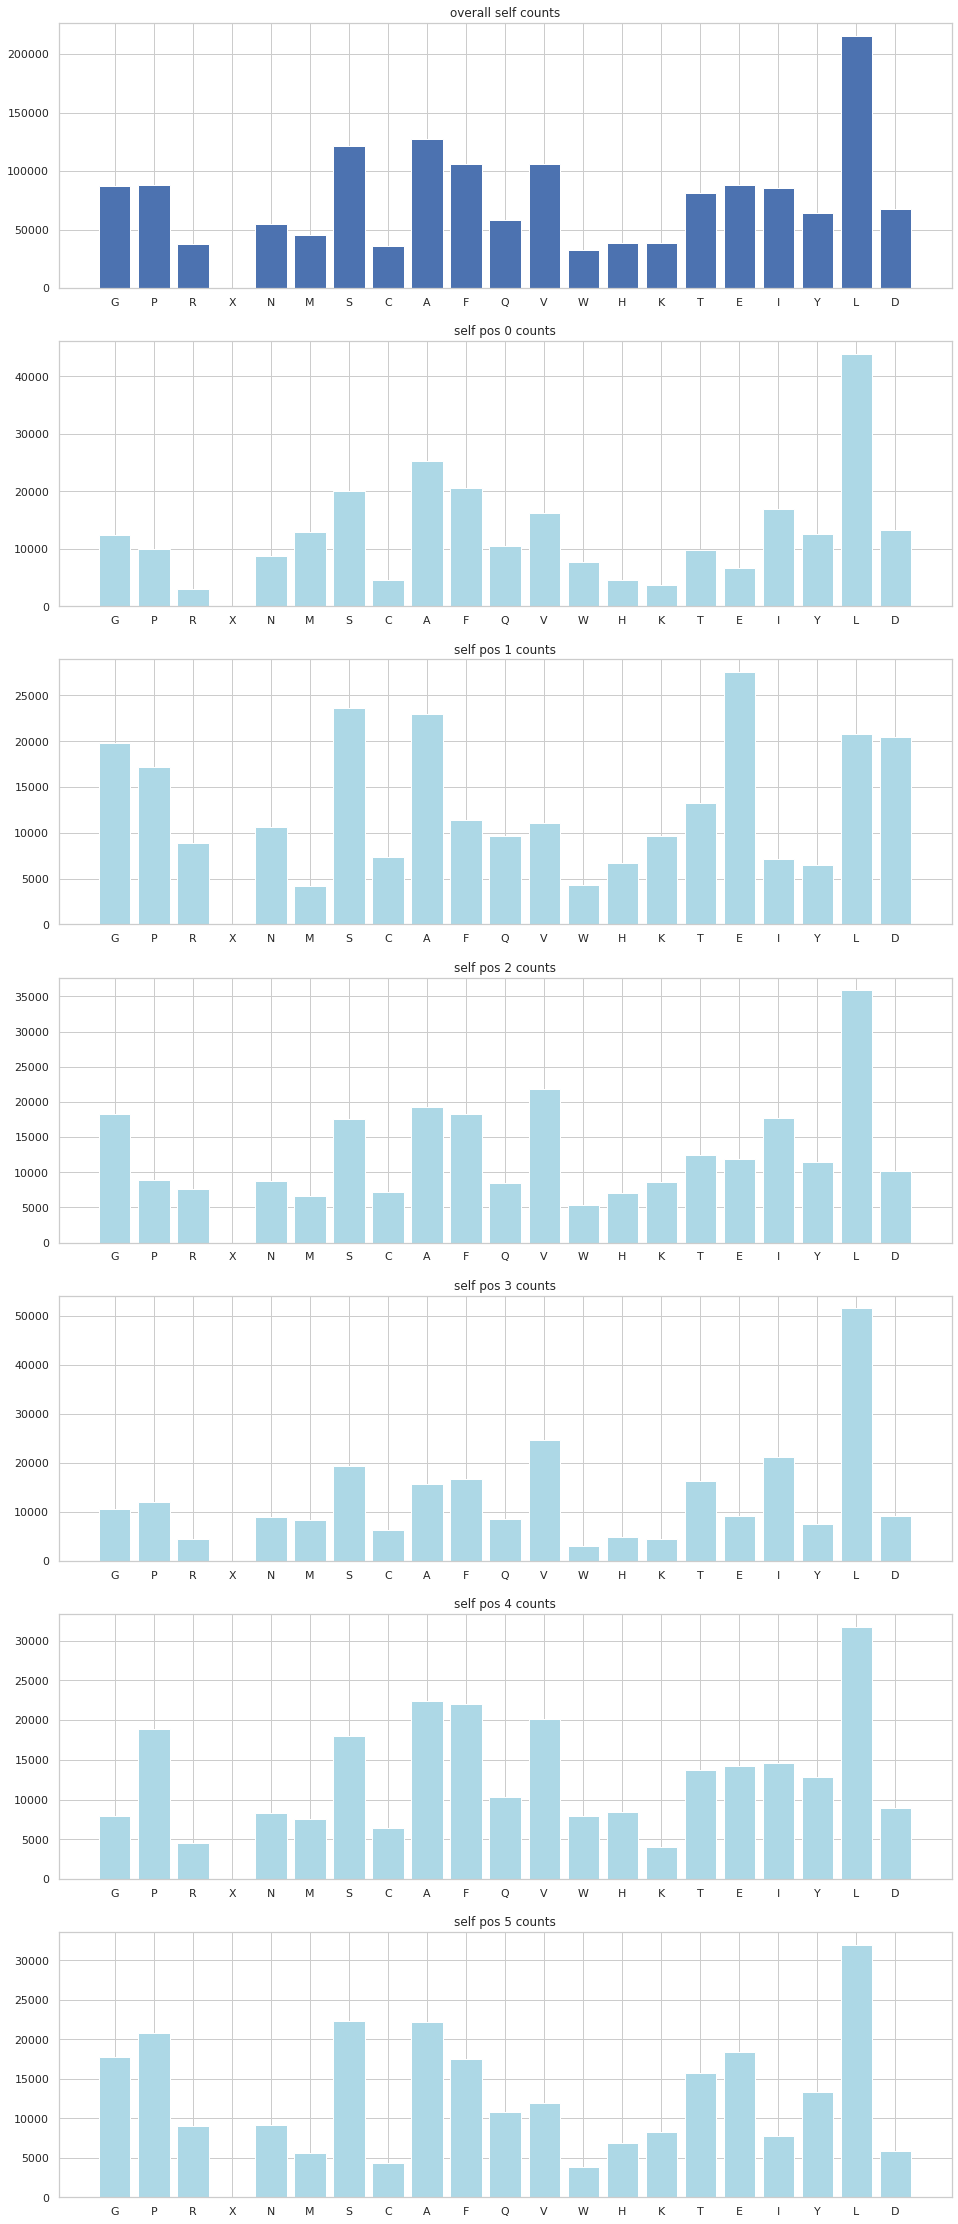

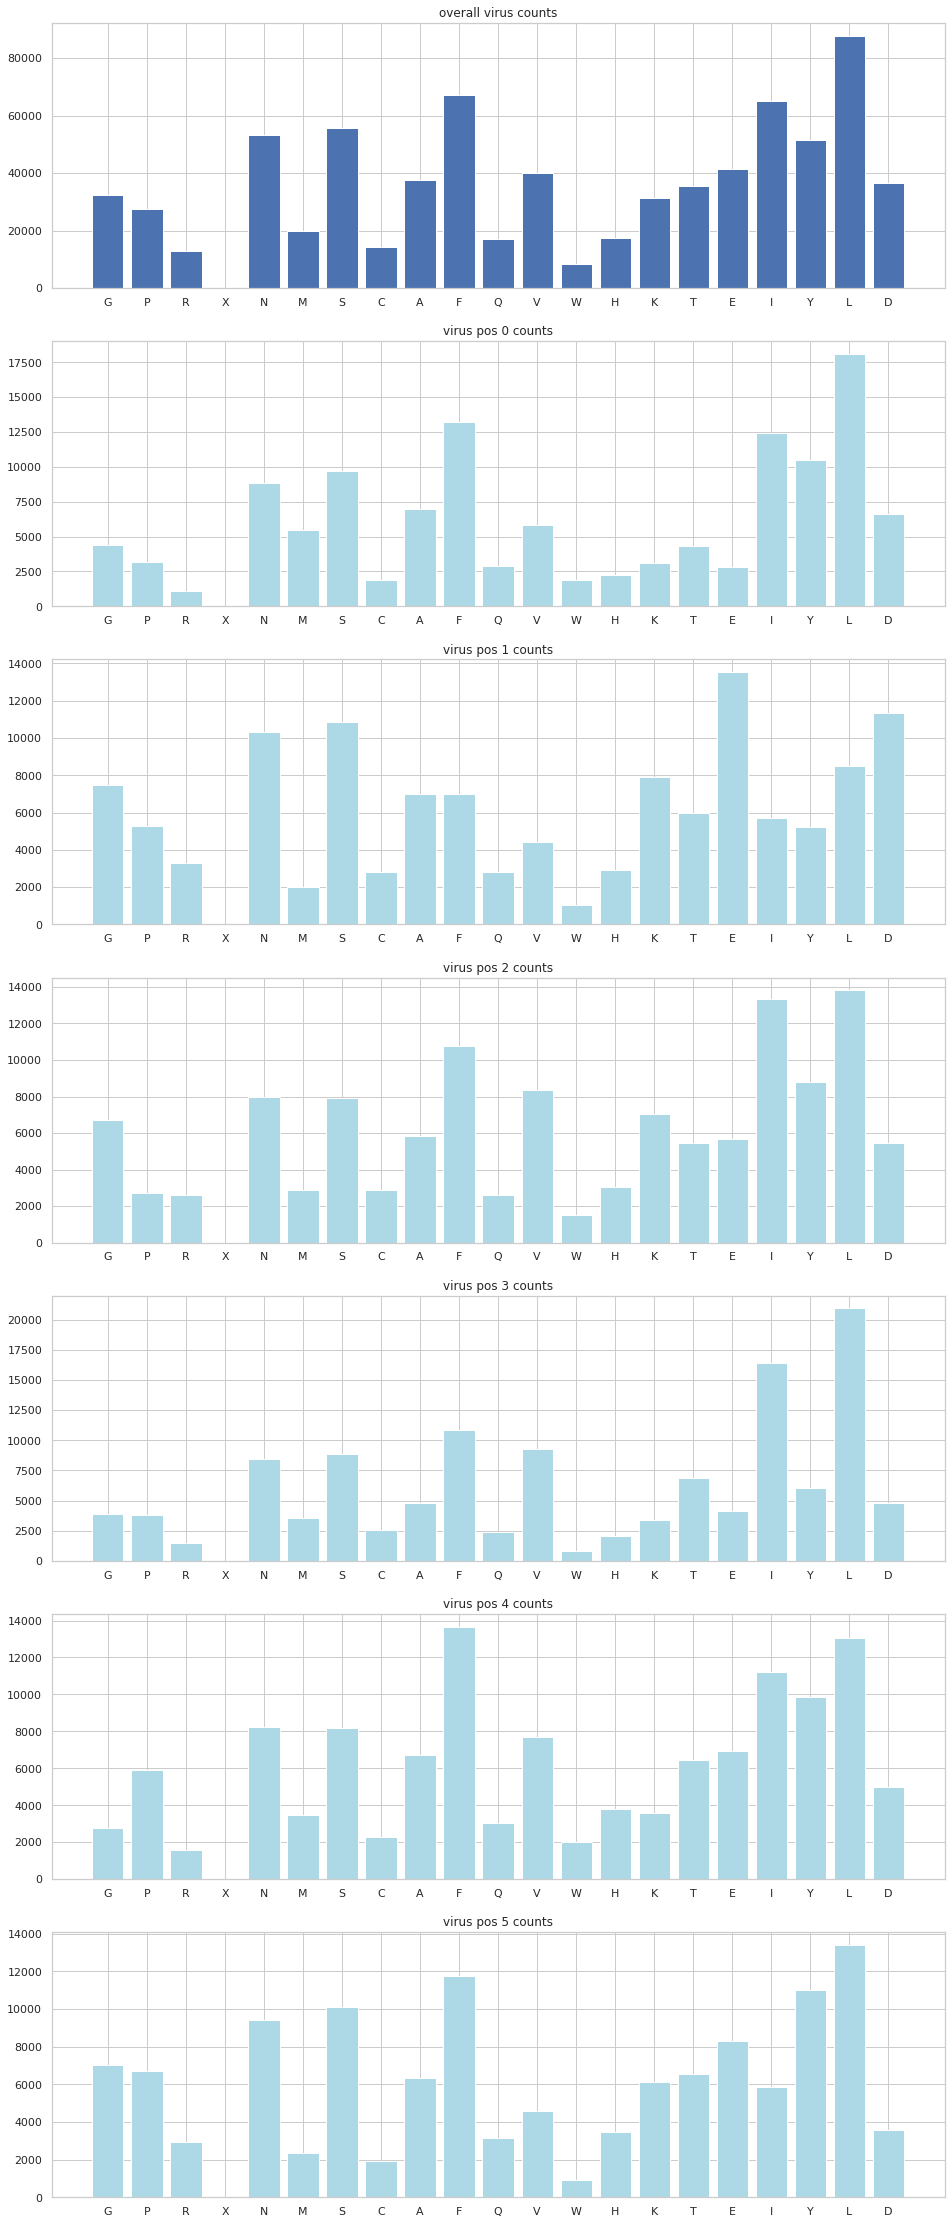

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

unique_aminos = list(unique_aminos)
amino_to_index = {}
for i, amino in enumerate(unique_aminos):
  amino_to_index[amino] = i

def get_distributions(peptides, name, skip_plots=False):
  counts = [0 for _ in unique_aminos]
  pos_counts = [
    [0 for _ in unique_aminos] for i in range(6)    
  ]
  
  for peptide in peptides:
    for i, amino in enumerate(peptide):
      index = amino_to_index[amino]
      counts[index] += 1
      pos_counts[i][index] += 1
  
  if not skip_plots:
    fig, axs = plt.subplots(7, figsize=(16, 40))
    axs[0].bar(unique_aminos, counts)
    axs[0].set_title('overall {} counts'.format(name))
    for i in range(6):
      axs[i + 1].bar(unique_aminos, pos_counts[i], color='lightblue')
      axs[i + 1].set_title('{} pos {} counts'.format(name, i))

  return counts, pos_counts
    
self_counts, self_pos_counts = get_distributions(self_peptides, 'self')
virus_counts, virus_pos_counts = get_distributions(virus_peptides, 'virus')

### Distances Between Self and Virus

In [86]:
import math
import random

EPSILON = 0.00000001

def kl_divergence(probs1, probs2):
  div = 0.0
  for i in range(len(probs1)):
    prob1, prob2 = probs1[i], probs2[i]
    if prob1 > EPSILON and prob2 > EPSILON:
      div += prob1 * (math.log2(prob1) -  math.log2(prob2))
  return div

def shannon_divergence(counts1, counts2):
  total_count1, total_count2 = sum(counts1), sum(counts2)
  probs1, probs2 = [], []
  for count in counts1:
    prob = float(count) / total_count1
    probs1.append(prob)
  for count in counts2:
    prob = float(count) / total_count2
    probs2.append(prob)

  avg_probs = []
  for i in range(len(probs1)):
    prob1, prob2 = probs1[i], probs2[i]
    avg_probs.append((prob1 + prob2) / 2)

  return (kl_divergence(probs1, avg_probs) + kl_divergence(probs2, avg_probs)) / 2

print('shannon div btw self and self = {}'.format(
    shannon_divergence(self_counts, self_counts)))
print('shannon div btw self and virus = {}'.format(
    shannon_divergence(self_counts, virus_counts)))
for i in range(6):
  s_counts = self_pos_counts[i]
  v_counts = virus_pos_counts[i]
  print('shannon div btw self and virus at pos {} = {}'.format(
      i, shannon_divergence(s_counts, v_counts)))  
  
# Shannon divergences for random samples of self and virus.
for _ in range(4):
  self_subset1 = random.choices(self_peptides, k=1000)
  self_subset2 = random.choices(self_peptides, k=1000)
  self_counts1, _ = get_distributions(self_subset1, '', skip_plots=True)
  self_counts2, _ = get_distributions(self_subset2, '', skip_plots=True)
  virus_subset1 = random.choices(virus_peptides, k=1000)
  virus_subset2 = random.choices(virus_peptides, k=1000)
  virus_counts1, _ = get_distributions(virus_subset1, '', skip_plots=True)
  virus_counts2, _ = get_distributions(virus_subset2, '', skip_plots=True)  
  print('\nshannon div btw self and self samples = {}'.format(
      shannon_divergence(self_counts1, self_counts2)))  
  print('shannon div btw virus and virus samples = {}'.format(
        shannon_divergence(virus_counts1, virus_counts2)))
  print('shannon div btw self and virus samples = {}'.format(
        shannon_divergence(self_counts1, virus_counts1)))  

shannon div btw self and self = 0.0
shannon div btw self and virus = 0.021370166110838
shannon div btw self and virus at pos 0 = 0.024122676406563116
shannon div btw self and virus at pos 1 = 0.020465810013496448
shannon div btw self and virus at pos 2 = 0.01999425676247295
shannon div btw self and virus at pos 3 = 0.019744811508847264
shannon div btw self and virus at pos 4 = 0.02216833771182572
shannon div btw self and virus at pos 5 = 0.023342611871842237

shannon div btw self and self samples = 0.0014110194524903838
shannon div btw virus and virus samples = 0.000784271795836352
shannon div btw self and virus samples = 0.027271918153068647

shannon div btw self and self samples = 0.0012230135674279722
shannon div btw virus and virus samples = 0.0008311685607716346
shannon div btw self and virus samples = 0.025020118244640677

shannon div btw self and self samples = 0.0012222720740042846
shannon div btw virus and virus samples = 0.0005065414041169124
shannon div btw self and virus sa

## Clustering